# Setup Enviorment

In [1]:
#!pip install tensorflow-addons
#!pip install epiweeks

In [77]:
import os
import shutil

import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from epiweeks import Week
from datetime import date as convert_to_date

In [78]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Main Directory
path = 'Dataset/'

### See an example of the data

#### 1. Features

In [81]:
bands = [1,2,3]

import matplotlib.pyplot as plt
def show_image(bands, image, size=6):
    print(f'The shape of the image is: {image.shape}')
    plt.figure(figsize=(size, size))
    plt.imshow(image[:,:,bands])
    plt.show()

---------- Cali ----------
The city has 165 images
The shape of the image is: (745, 748, 12)


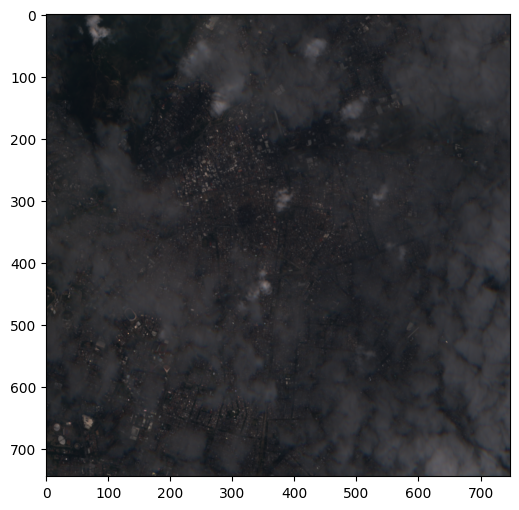

---------- Cúcuta ----------
The city has 165 images
The shape of the image is: (751, 742, 12)


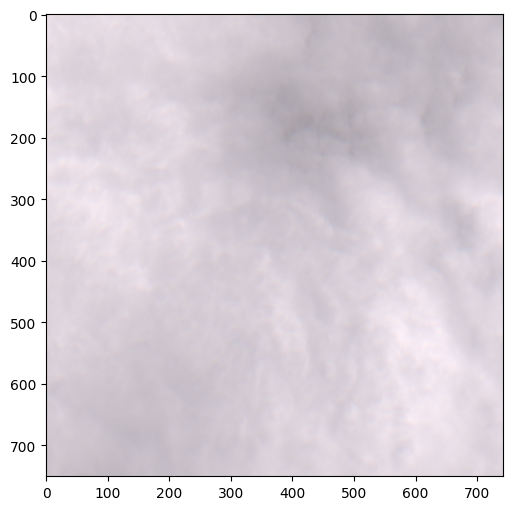

---------- Villavicencio ----------
The city has 165 images
The shape of the image is: (747, 745, 12)


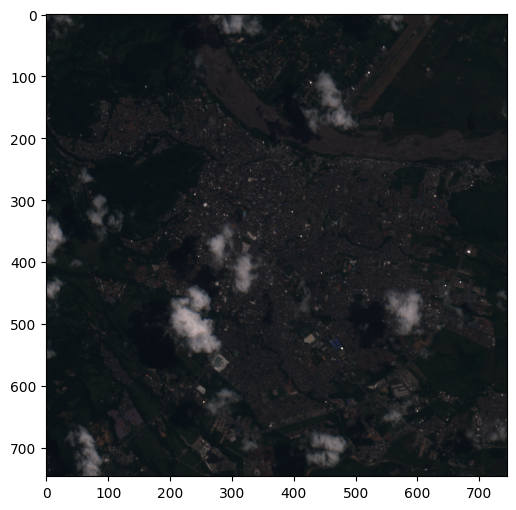

---------- Ibagué ----------
The city has 165 images
The shape of the image is: (746, 746, 12)


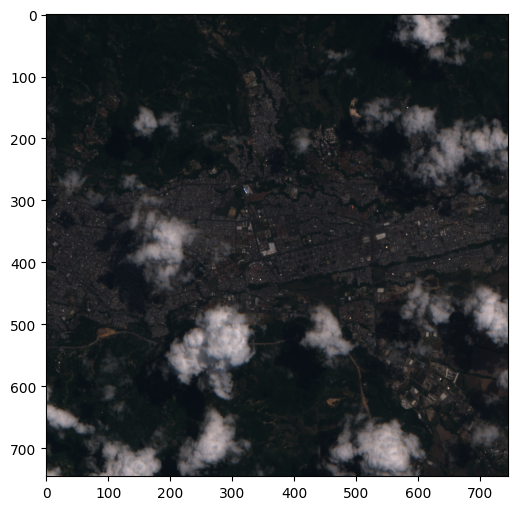

---------- Medellín ----------
The city has 165 images
The shape of the image is: (745, 747, 12)


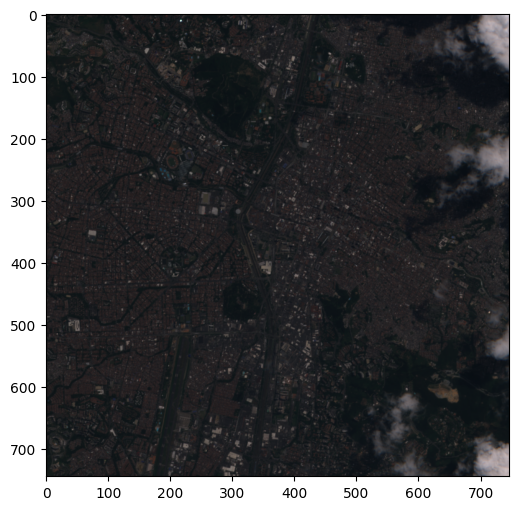

In [82]:
for city in os.listdir(path):
    images_path = os.path.join(path, city)
    print(f'---------- {city} ----------')
    print(f'The city has {len(os.listdir(images_path))} images')
    # Get the fist image
    image_path = os.path.join(images_path, os.listdir(images_path)[0])
    # read the image
    image_tiff = io.imread(image_path)
    show_image(bands, image_tiff)

#### 2. Lables

In [83]:
dengue_cases = pd.read_csv('Dengue_dataset/cases_classes.csv')

names = dengue_cases[dengue_cases.columns[:2]]

# Convert epiweeks to int:
cases = dengue_cases[dengue_cases.columns[2:]]
cases.columns = cases.columns.to_series().apply(lambda x: int(x))

# Merge:
dengue_cases = pd.concat([names, cases], axis=1)

dengue_cases

,Municipality code,Municipality,200701,200702,200703,200704,200705,200706,200707,200708,...,201943,201944,201945,201946,201947,201948,201949,201950,201951,201952
0,5001,Medellín,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5002,Abejorral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5004,Abriaquí,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5021,Alejandría,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5030,Amagá,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,97889,Yavaraté,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1117,99001,Puerto Carreño,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1118,99524,La Primavera,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1119,99624,Santa Rosalía,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Read dataset

In [84]:
image_list = []
image_dir = {}

cities = os.listdir(path)
for city in cities:
    # Get path to city:
    images_path = os.path.join(path, city)
    image_dir[city] = os.listdir(images_path)
    for image in os.listdir(images_path):
        # make sure file is an image
        if image.endswith(('.jpg', '.png', 'jpeg', 'tiff')):
            # Get path to image:
            image_path = os.path.join(images_path, image)
            #img_path = path + file
            image_list.append(image_path)

print(f'Image list top 5 examples of length {len(image_list)}:')
#image_dir
image_list[:5]

Image list top 5 examples of length 825:


['DATASET_5_best_cities/Cali/image_2017-07-30.tiff',
 'DATASET_5_best_cities/Cali/image_2015-12-20.tiff',
 'DATASET_5_best_cities/Cali/image_2017-11-19.tiff',
 'DATASET_5_best_cities/Cali/image_2016-11-20.tiff',
 'DATASET_5_best_cities/Cali/image_2017-07-16.tiff']

# Train-Test Split

In [85]:
# Train-Test split
image_list = np.array(image_list)
x_train, x_test = train_test_split(image_list,test_size=0.2)
#x_train, x_val = train_test_split(x_train,test_size=0.1)

In [86]:
# To numpy
x_train = np.array(x_train)
#x_val = np.array(x_val)
x_test = np.array(x_test)

# Create a custom dataloader

In [87]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, image_paths,
                 batch_size,
                 input_size = (224, 224, 8),
                 shuffle = True, 
                 df = None):
        
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.df = df
        # Length of dataset
        self.n = len(self.image_paths)
        
    def __get_epiweek(self, image_name):
        date = image_name.split('-')
        # Get year as int
        year = ''.join(filter(str.isdigit, date[0]))
        year = int(year)
        # Get month as int
        month = ''.join(filter(str.isdigit, date[1]))
        month = int(month)
        # Get day as int
        day = ''.join(filter(str.isdigit, date[2]))
        day = int(day)
        # Get epiweek:
        date = convert_to_date(year, month, day)
        epiweek = str(Week.fromdate(date))
        epiweek = int(epiweek)
        return epiweek
    
    def __get_label(self, path):
        # Get city:
        city = path.split('/')[1]
        # Get epiweek:
        date = path.split('/')[2]
        epiweek = self.__get_epiweek(date)
        # Get cases:
        cases = int(self.df[self.df['Municipality'] == city].loc[:,epiweek])
        return cases
        
        
    # Helper function to read the image
    def __get_image(self, path, target_size):
        # Read the image and convert to numpy array
        image = io.imread(path)
        # Resize the image and normalize values
        image_arr = resize(image,(target_size[0], target_size[1]))
        #print(f'The shape of the image before reshape: {image_arr.shape}, of type{type(image_arr)}')
        return image_arr
    
    def __getitem__(self, index):     
        batches = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        y_batch = []
        # for each image in batch
        for image_name in batches:
            # Get the image
            image = self.__get_image(image_name, self.input_size)
            X_batch.append(image)
            # Get the label
            label = self.__get_label(image_name)
            y_batch.append(label)
            
        y_batch = np.array(y_batch)
        X_batch = np.array(X_batch)
        
        #print(f'The shape of the batch is : {X_batch.shape} of type: {type(X_batch)}')
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)
            
    def __len__(self):
        return self.n // self.batch_size

In [88]:
batch_size = 16
num_classes = 2
target_size = (512, 512, 12)
traingen = CustomDataGen(x_train,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         df=dengue_cases, 
                         shuffle = True)

In [89]:
testgen = CustomDataGen(x_test,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         df=dengue_cases)

## Data Visualization

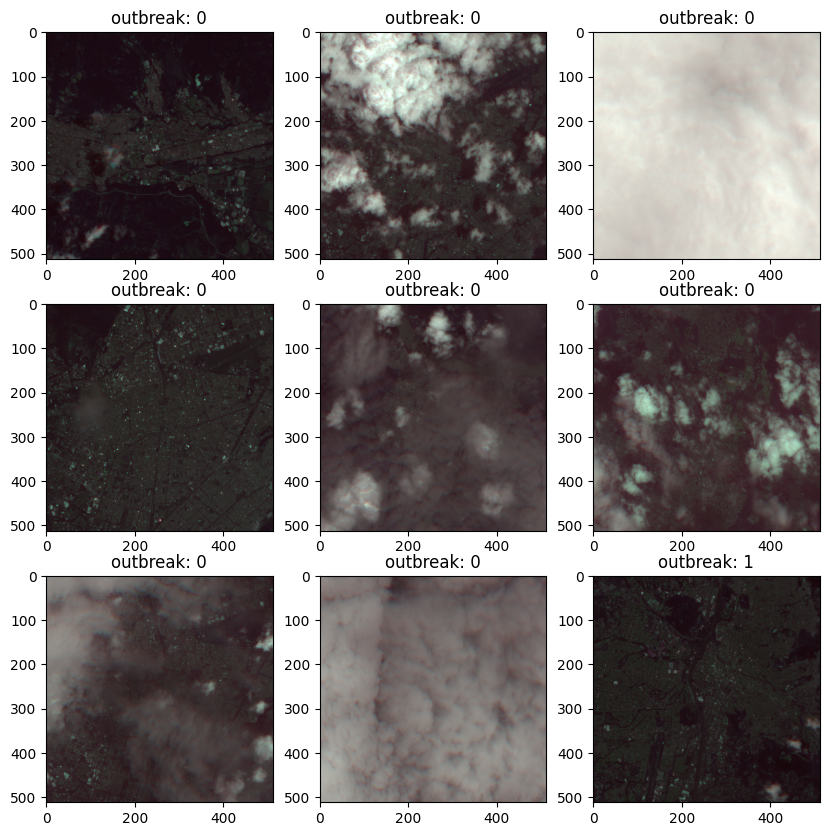

In [90]:
example_gen = CustomDataGen(x_test,
                             batch_size=batch_size, 
                             input_size=target_size, 
                             df=dengue_cases, 
                             shuffle = True)
for x,y in example_gen:
    x, y = x, y
    break

ax = plt. subplots(3, 3, figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)

    # plot raw pixel data
    plt.imshow(x[i, :, :, 0:3])
    plt.title(f'outbreak: {y[i]}')
    
# show the figure
plt.show()

# Data Augmentation

In [91]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Model
* https://keras.io/examples/vision/supervised-contrastive-learning/

In [92]:
learning_rate = 0.001
hidden_units = 512
projection_units = 128
dropout_rate = 0.5
temperature = 0.05

In [93]:
tf.random.set_seed(1234)

### Encoder

In [94]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=target_size, pooling="avg"
    )

    inputs = keras.Input(shape=target_size)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="dengue_sat-encoder")
    return model


In [95]:
encoder = create_encoder()
encoder.summary()

Model: "dengue_sat-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 512, 512, 12)]    0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 12)    0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23593024  
Total params: 23,593,024
Trainable params: 23,547,584
Non-trainable params: 45,440
_________________________________________________________________


### Classifier

In [96]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=target_size)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="dengue_sat-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

### Train a Resnet 50 classification model

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

In [98]:
def plot_hisory(history):
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [99]:
def train_classifier(epochs=100):
    encoder = create_encoder()
    classifier = create_classifier(encoder)
    classifier.summary()

    history = classifier.fit(traingen,
                              validation_data=testgen,
                              epochs=epochs,
                              callbacks=[monitor]
    )
    
    plot_hisory(history)
    
    return classifier

Model: "dengue_sat-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 512, 512, 12)]    0         
_________________________________________________________________
dengue_sat-encoder (Function (None, 2048)              23593024  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 1026      
Total params: 24,643,138
Trainable params: 24,597,698
Non-trainable params: 45,440
____________________________

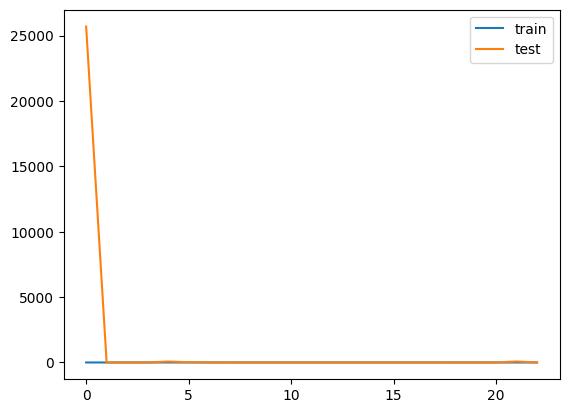

In [100]:
classifier = train_classifier(epochs=100)

In [101]:
def evaluate(classifier):
    accuracy = classifier.evaluate(testgen)[1]
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [102]:
evaluate(classifier)

10/10 [==============================] - 70s 7s/step - loss: 0.4707 - sparse_categorical_accuracy: 0.7812
Test accuracy: 78.12%


## Supervised contrastive learning

In [66]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [67]:
def add_projection_head(encoder):
    inputs = keras.Input(shape=target_size)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="dengue_sat-encoder_with_projection-head"
    )
    return model

### Pretrain the encoder

In [68]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)

encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

Model: "dengue_sat-encoder_with_projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 512, 512, 12)]    0         
_________________________________________________________________
dengue_sat-encoder (Function (None, 2048)              23593049  
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
Total params: 23,855,321
Trainable params: 23,809,856
Non-trainable params: 45,465
_________________________________________________________________


Epoch 1/100
41/41 [==============================] - 337s 8s/step - loss: 2.8866 - val_loss: 2.7724
Epoch 2/100
41/41 [==============================] - 326s 8s/step - loss: 2.7666 - val_loss: 2.7709
Epoch 3/100
41/41 [==============================] - 326s 8s/step - loss: 2.7667 - val_loss: 2.7674
Epoch 4/100
41/41 [==============================] - 312s 8s/step - loss: 2.7630 - val_loss: 2.7662
Epoch 5/100
41/41 [==============================] - 308s 7s/step - loss: 2.7650 - val_loss: 2.7790
Epoch 6/100
41/41 [==============================] - 308s 7s/step - loss: 2.7698 - val_loss: 2.7652
Epoch 7/100
41/41 [==============================] - 308s 7s/step - loss: 2.7654 - val_loss: 2.7698
Epoch 8/100
41/41 [==============================] - 331s 8s/step - loss: 2.7624 - val_loss: 2.7608
Epoch 9/100
41/41 [==============================] - 317s 8s/step - loss: 2.7629 - val_loss: 2.7724
Epoch 10/100
41/41 [==============================] - 325s 8s/step - loss: 2.7661 - val_loss: 2.7713

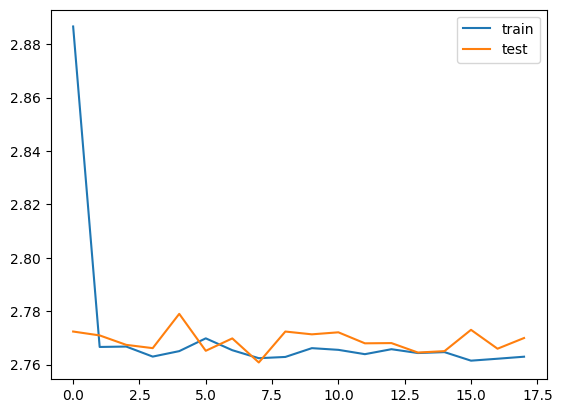

In [70]:
history = encoder_with_projection_head.fit(traingen,
                                           validation_data=testgen,
                                           epochs=100,
                                           callbacks=[monitor]
)

plot_hisory(history)

In [71]:
# Save the model
encoder_with_projection_head.save('Models/contrastive_learning_encoder_with_projection_head.h5')

In [72]:
encoder.save('Models/contrastive_learning_resnet50v2.h5')

### Train the classifier with the frozen encoder

Epoch 1/100
41/41 [==============================] - 266s 6s/step - loss: 2.4702 - sparse_categorical_accuracy: 0.6829 - val_loss: 0.5667 - val_sparse_categorical_accuracy: 0.7437
Epoch 2/100
41/41 [==============================] - 274s 7s/step - loss: 0.8017 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.6117 - val_sparse_categorical_accuracy: 0.6812
Epoch 3/100
41/41 [==============================] - 245s 6s/step - loss: 0.6180 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.5039 - val_sparse_categorical_accuracy: 0.8500
Epoch 4/100
41/41 [==============================] - 270s 7s/step - loss: 0.5460 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.4651 - val_sparse_categorical_accuracy: 0.8375
Epoch 5/100
41/41 [==============================] - 259s 6s/step - loss: 0.5665 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.4664 - val_sparse_categorical_accuracy: 0.8438
Epoch 6/100
41/41 [==============================] - 255s 6s/step - loss: 0.5581 - sparse_categorica

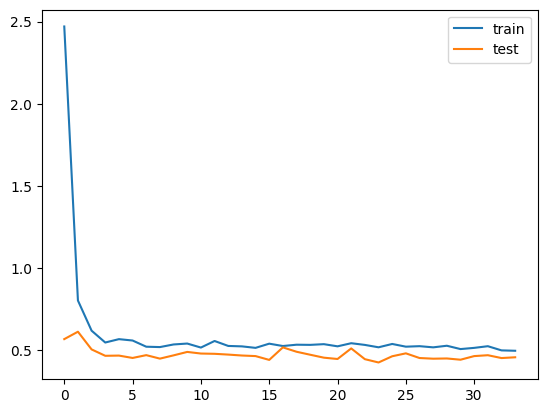

In [73]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(traingen,
                          validation_data=testgen,
                          epochs=100,
                          callbacks=[monitor]
)
    
plot_hisory(history)

In [74]:
evaluate(classifier)

10/10 [==============================] - 42s 4s/step - loss: 0.4526 - sparse_categorical_accuracy: 0.8313
Test accuracy: 83.13%


In [75]:
classifier.save('Models/contrastive_learning_classifier_resnet50v2.h5')